### 2차원 Spectrogram 데이터를 입력받아 Text 라벨을 출력하는 모델을 만들어보자.

### Step 1. Data Open

In [1]:
import os
import random
import librosa
import matplotlib.pyplot as plt
import IPython.display as ipd

import tensorflow as tf
import tensorflow.keras as keras
import numpy as np

from sklearn.model_selection import train_test_split

In [2]:
# data가 있는 경로로 설정해주세요
data_path = os.getenv("HOME")+"/aiffel/speech_recognition/data/speech_wav_8000.npz"
speech_data = np.load(data_path)

In [3]:
#np.load(.npz) => numpy array로 압축 풀어준다.
#안에 어떤 element name이 있는지 확인해보자
for x in speech_data.files:
    print(x)

wav_vals
label_vals


In [4]:
print("Wave data shape : ", speech_data["wav_vals"].shape)
print("Label data shape : ", speech_data["label_vals"].shape)

Wave data shape :  (50620, 8000)
Label data shape :  (50620, 1)


In [5]:
rand = random.randint(0, len(speech_data["wav_vals"]))
print("rand num : ", rand)

sr = 8000 # 1초동안 재생되는 샘플의 갯수
data =speech_data["wav_vals"][rand]
print("Wave data shape : ", data.shape)
print("label : ", speech_data["label_vals"][rand])

#ipd.Audio(data, rate=sr)

rand num :  48089
Wave data shape :  (8000,)
label :  ['silence']


### Step 2. Train/Test 데이터셋 구성하기

In [6]:
#label data 처리
target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

#위에 존재하지 않는 소리들은 'unknown' or 'silence'
label_value = target_list
label_value.append('unknown')
label_value.append('silence')

#str label을 indexing 해주기
new_label_value = dict()
for i, l in enumerate(label_value):
    new_label_value[l] = i #key : 단어 , value : index
label_value = new_label_value

In [7]:
len(target_list)

12

In [8]:
#단어를 인덱싱 했으니
#label 데이터를 해당하는 번호(str->int)로 바꿔주자.
temp = []
for v in speech_data["label_vals"]:
    temp.append(label_value[v[0]])
label_data = np.array(temp)

### 학습을 위한 데이터 분리
  
train_test_split(array data를 넣어주고 비율에 맞게 나눠준다.)

In [9]:
train_wav, test_wav, train_label, test_label = train_test_split(speech_data["wav_vals"],
                                                               label_data,
                                                               test_size=0.1,
                                                               shuffle=True)

### Hyper parameter setting

In [10]:
BATCH_SIZE = 16
MAX_EPOCH = 10
checkpoint_dir = os.getenv("HOME")+"/aiffel/speech_recognition/model/wav"

In [11]:
from tqdm import tqdm

def one_hot_label(wav, label):
    label = tf.one_hot(label, depth = 12)
    return wav, label

# Wav => Spectrogram
def wav2spec(waves):
    D = []
    for wav in tqdm(waves):
        D.append(np.abs(librosa.stft(wav, n_fft=258)))
    D = np.array(D)
    return D

In [12]:
# wav => Spectogram 변환하기
train_wav = wav2spec(train_wav)
test_wav = wav2spec(test_wav)

100%|██████████| 5062/5062 [00:03<00:00, 1686.47it/s]


In [13]:
# 파일 저장하기
# np.save(os.getcwd()+"train", train_wav)
# np.save(os.getcwd()+"test", test_wav)

In [14]:
# 원하면 불러올 수 있다.
# train_wav = np.load(os.getcwd()+"train.npy")
# test_wav = np.load(os.getcwd()+"test.npy")

In [15]:
train_wav.shape

(45558, 130, 126)

In [16]:
#add channel for CNN
#np.newaxis <-> np.squeeze
#train_wav = train_wav.reshape([-1, train_wav.shape[1], train_wav.shape[2], 1])
#test_wav = test_wav.reshape([-1, test_wav.shape[1], test_wav.shape[2], 1])
train_wav = train_wav[:,:,:,np.newaxis]
test_wav = test_wav[:,:,:,np.newaxis]

In [17]:
print("train data : ", train_wav.shape)
print("train labels : ", train_label.shape)
print("test data : ", test_wav.shape)
print("test labels : ", test_label.shape)

train data :  (45558, 130, 126, 1)
train labels :  (45558,)
test data :  (5062, 130, 126, 1)
test labels :  (5062,)


Train data set을 다시 train data, validation data로 나눠주기 위한 코드  
Train dataset을 9:1의 비율로 나눠 준다.

In [18]:
traindata_size = int(0.9 * train_label.shape[0])
validdata_size = len(train_label) - traindata_size

In [19]:
print(f"Train data size : {traindata_size} \nValidation data size : {validdata_size}")

Train data size : 41002 
Validation data size : 4556


In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_wav, train_label))

# (train_wav, train_label)을 traindata_size만큼 skip하고 valid_dataset에 담아준다.
valid_dataset = train_dataset.skip(traindata_size)

In [22]:
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.repeat().batch(batch_size=BATCH_SIZE)

valid_dataset = valid_dataset.map(one_hot_label)
valid_dataset = valid_dataset.repeat().batch(batch_size=BATCH_SIZE)

In [34]:
test_dataset = tf.data.Dataset.from_tensor_slices((test_wav, test_label))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size = BATCH_SIZE)

학습데이터가 잘 변환되었는지 확인해보자.

In [25]:
sample = next(iter(train_dataset))
sample_spec = sample[0]

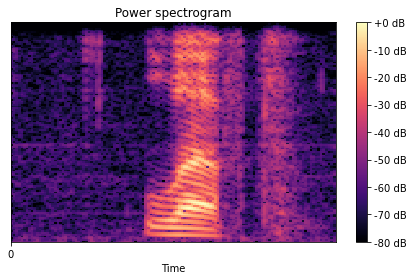

In [26]:
import librosa.display
sample_in_minibatch = 8

#Shape을 줄일땐 0을 넣어주거나, np.squeeze()[1을 없애줌]를 사용하자
librosa.display.specshow(librosa.amplitude_to_db(sample_spec[sample_in_minibatch,:,:,0], ref=np.max), x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.xticks(range(0, 1))
plt.tight_layout()
plt.show()

### Step 3. Model

### Skip-Connection model

In [27]:
from tensorflow.keras import layers

input_tensor = layers.Input(shape=(130,126, 1))

x = layers.Conv2D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv2D(32, 9, padding='same', activation='relu')(x)
skip_1 = layers.MaxPool2D()(x)

x = layers.Conv2D(64, 9, padding='same', activation='relu')(skip_1)
x = layers.Conv2D(64, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_1], -1)
skip_2 = layers.MaxPool2D()(x)

x = layers.Conv2D(128, 9, padding='same', activation='relu')(skip_2)
x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_2], -1)
skip_3 = layers.MaxPool2D()(x)

x = layers.Conv2D(256, 9, padding='same', activation='relu')(skip_3)
x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_3], -1)
x = layers.MaxPool2D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_wav_skip = tf.keras.Model(input_tensor, output_tensor)

# model_wav_skip.summary()

In [28]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_wav_skip.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])

In [29]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/wav_skip'

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [30]:
history_wav_skip = model_wav_skip.fit(train_dataset, epochs=MAX_EPOCH,
                    steps_per_epoch=len(train_wav) // BATCH_SIZE,
                    validation_data=valid_dataset,
                    validation_steps=validdata_size // BATCH_SIZE,
                    callbacks=[cp_callback, es_callback]
                    )

Epoch 1/10
2847/2847 [==============================] - ETA: 0s - loss: 0.6471 - accuracy: 0.7909
Epoch 00001: val_loss improved from inf to 0.14940, saving model to /home/aiffel0042/aiffel/speech_recognition/models/wav_skip
2847/2847 [==============================] - 330s 116ms/step - loss: 0.6471 - accuracy: 0.7909 - val_loss: 0.1494 - val_accuracy: 0.9544
Epoch 2/10
2847/2847 [==============================] - ETA: 0s - loss: 0.2147 - accuracy: 0.9330
Epoch 00002: val_loss improved from 0.14940 to 0.08659, saving model to /home/aiffel0042/aiffel/speech_recognition/models/wav_skip
2847/2847 [==============================] - 344s 121ms/step - loss: 0.2147 - accuracy: 0.9330 - val_loss: 0.0866 - val_accuracy: 0.9729
Epoch 3/10
2847/2847 [==============================] - ETA: 0s - loss: 0.1444 - accuracy: 0.9536
Epoch 00003: val_loss improved from 0.08659 to 0.07740, saving model to /home/aiffel0042/aiffel/speech_recognition/models/wav_skip
2847/2847 [==============================] 

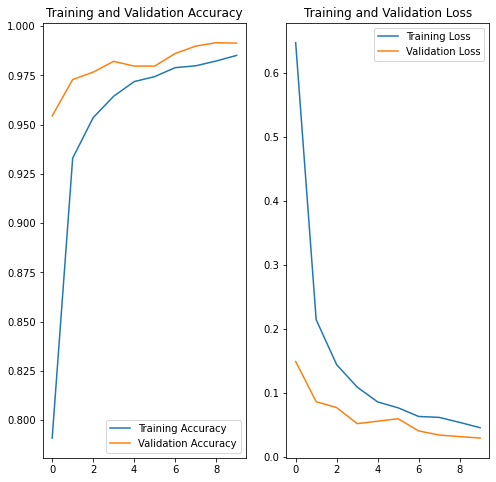

In [32]:
acc = history_wav_skip.history['accuracy']
val_acc = history_wav_skip.history['val_accuracy']

loss=history_wav_skip.history['loss']
val_loss=history_wav_skip.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [35]:
# model_wav_skip.load_weights(checkpoint_dir)
results = model_wav_skip.evaluate(test_dataset)

317/317 [==============================] - 24s 77ms/step - loss: 0.1015 - accuracy: 0.9706
